# Pylops - local Transorms (e.g. sliding Radon)

In this notebook we will consider the case a linear or Radon transform can only be used to explain a certain 2d signal (e.g. seismic data) locally. We will thus develop a sliding window operator that takes N representations of portion of the signal in the Radon domain, converts them to the time-space domain and combines them via a sliding window approach (with tapering and overlap)

Mathematically speaking we will have an operator

$$\mathbf{SW} = \mathbf{Combine} * \mathbf{Op} * \mathbf{Slice}$$

where $\mathbf{Slice}$ extracts patches of the model, $\mathbf{Op}$ applies the same operator (e.g., forward Radon) to each patch, $\mathbf{Combine}$ recombines the outputs of $\mathbf{Op}$ (possibly with sliding windows and overlaps).

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import LinearOperator, cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import IRLS as IRLSpylops
from pylops.optimization.sparsity  import FISTA

We start by creating a data with 3 hyperbolic events

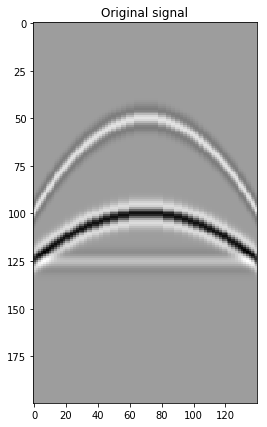

In [2]:
###### Input parameters
par = {'ox':-140, 'dx':2,    'nx':140,
       'ot':0, 'dt':0.004,'nt':200,
       'f0': 20}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
px_m = [0, 0, 0]
pxx_m = [1e-5, 5e-6, 1e-20]
amp_m   = [1., -2, 0.5]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, data =  parabolic2d(x,t, t0_m, px_m, pxx_m,amp_m,wav)

plt.figure(figsize=(4,7))
plt.imshow(data.T, cmap='gray')
plt.title('Original signal')
plt.axis('tight');

We then subdivide the data into several patches (along the space axis) and compute the radon transform for each patch and recombine them to remake the data. Patches are adjacent here with no overlap

In [3]:
nwin = 20
nover = 0
dims = data.shape
npx=20
px = np.linspace(-5e-3, 5e-3, npx)

Op=Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), 
           px, centeredh=True, kind='linear', onthefly=False)
Slid = Sliding2D(Op, dims, dims, nwin, 0, tapertype='hanning')
dottest(Slid, par['nx']*par['nt'], par['nx']*par['nt'])

radon = Slid.H * data.flatten()
radon = radon.reshape(dims)
reconstructed_data = Slid * radon.flatten()
reconstructed_data = reconstructed_data.reshape(dims)

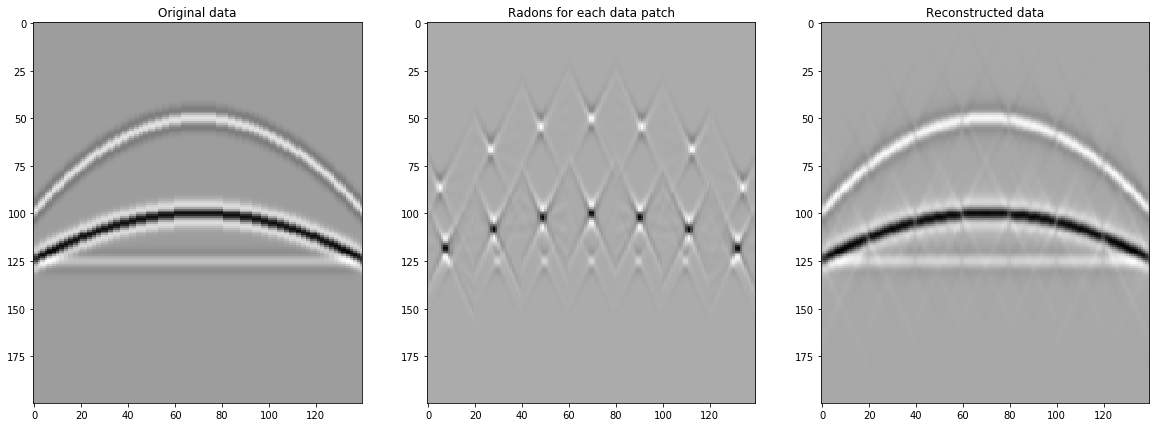

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
axs[0].imshow(data.T, cmap='gray')
axs[0].set_title('Original data')
axs[0].axis('tight')
axs[1].imshow(radon.T, cmap='gray')
axs[1].set_title('Radons for each data patch')
axs[1].axis('tight')
axs[2].imshow(reconstructed_data.T, cmap='gray')
axs[2].set_title('Reconstructed data')
axs[2].axis('tight');

Let's use sliding windows now

In [24]:
nwin=36
nwins=5
nover=10
npx=61
px = np.linspace(-5e-3, 5e-3, npx)
dimsd = data.shape
dims = (nwins*npx, dimsd[1])

# sliding window radon without taper
Op = Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), px, centeredh=True,
                         kind='linear', engine='numba')
Slid = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype=None)
dottest(Slid, np.prod(data.shape), npx*nwins*par['nt'])

radon = Slid.H * data.flatten()
radon = radon.reshape(dims)

We now go back to the time-space domain but we patch the various radons with overlapping tapered windows 

In [14]:
# sliding window radon with overlap
Op = Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), px, centeredh=True,
                          kind='linear', engine='numba')
Slid1 = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine')
dottest(Slid, np.prod(data.shape), npx*nwins*par['nt'])

reconstructed_data = Slid1 * radon.flatten()
reconstructed_data = reconstructed_data.reshape(dimsd)

[  0  26  52  78 104] [ 36  62  88 114 140]


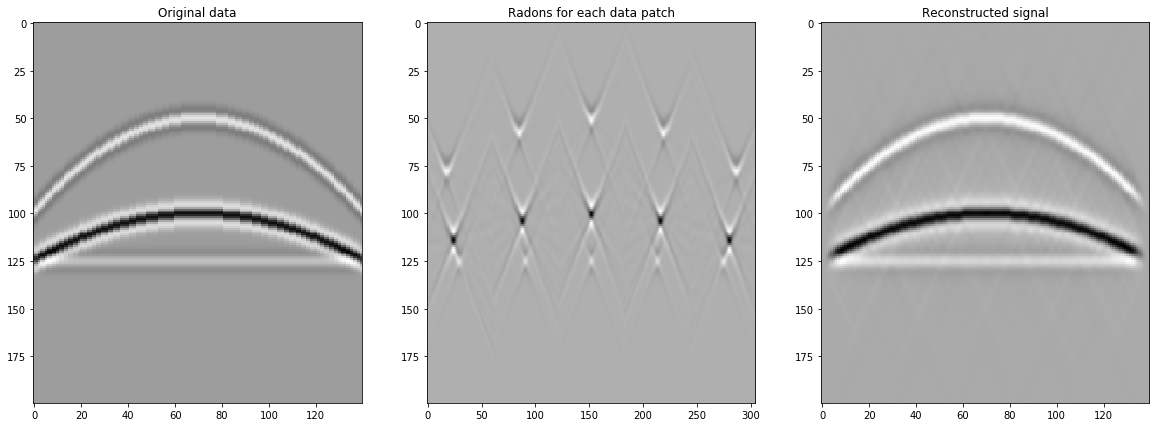

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
axs[0].imshow(data.T, cmap='gray')
axs[0].set_title('Original data')
axs[0].axis('tight')
axs[1].imshow(radon.T, cmap='gray')
axs[1].set_title('Radons for each data patch')
axs[1].axis('tight')
axs[2].imshow(reconstructed_data.T, cmap='gray')
axs[2].set_title('Reconstructed signal')
axs[2].axis('tight');

Finally we could also try to invert the operator with taper and then remake the data as forward model:

In [8]:
radoninv = LinearOperator(Slid1, explicit=False).div(data.flatten(), niter=30)
reconstructed_datainv = Slid1 * radoninv.flatten()

radoninv = radoninv.reshape(dims)
reconstructed_datainv = reconstructed_datainv.reshape(dimsd)

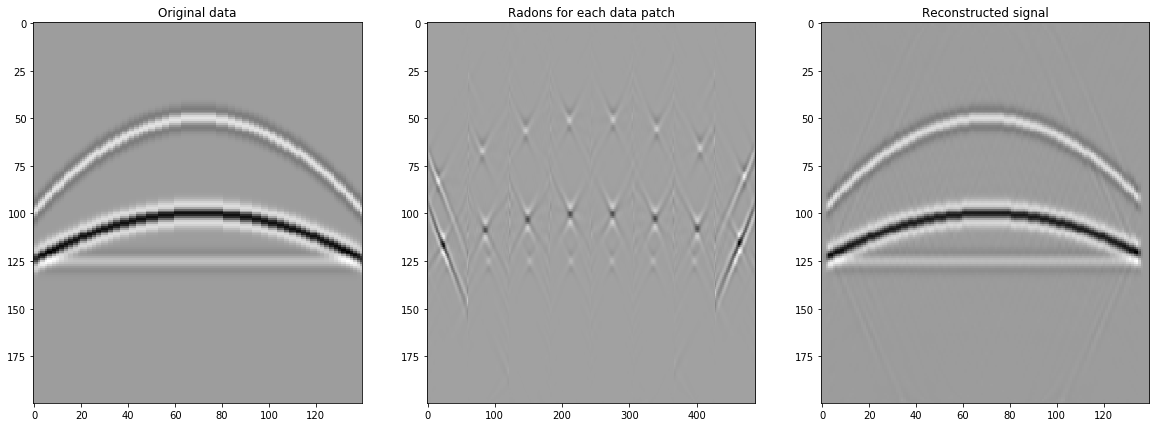

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
axs[0].imshow(data.T, cmap='gray')
axs[0].set_title('Original data')
axs[0].axis('tight')
axs[1].imshow(radoninv.T, cmap='gray')
axs[1].set_title('Radons for each data patch')
axs[1].axis('tight')
axs[2].imshow(reconstructed_datainv.T, cmap='gray')
axs[2].set_title('Reconstructed signal')
axs[2].axis('tight');

(-0.5, 139.5, 199.5, -0.5)

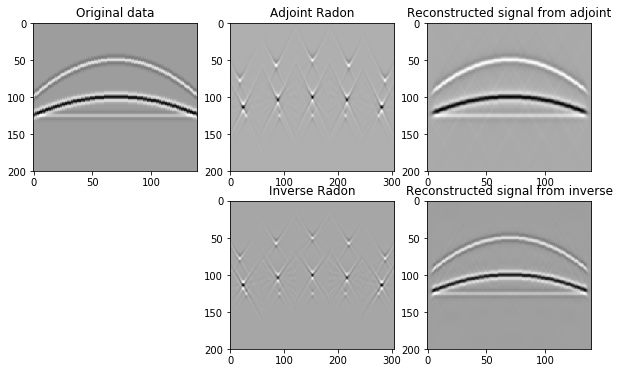

In [26]:
r"""
2D Sliding
==========
This example shows how to use the :py:class:`pylops.signalprocessing.Sliding2D`
operator to perform repeated transforms over small patches of a two dimensional
signal. The transform that we apply in this example is the
:py:class:`pylops.signalprocessing.Radon2D` but this operator has been
design to allow a variety of transforms as long as they operate with signals
that are two dimensional in nature.
"""
import numpy as np
import matplotlib.pyplot as plt

import pylops

plt.close('all')

###############################################################################
# Let's start by creating an 2d matrix of size :math:`n_x \times n_t`
# and composed of 3 parabolic events
par = {'ox':-140, 'dx':2, 'nx':140,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 20}

v = 1500
t0 = [0.2, 0.4, 0.5]
px = [0, 0, 0]
pxx = [1e-5, 5e-6, 1e-20]
amp = [1., -2, 0.5]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, data = pylops.utils.seismicevents.parabolic2d(x, t, t0, px,
                                                 pxx, amp, wav)

###############################################################################
# We start by divide this 2d dimensional data into small overlapping
# patches in the spatial direction and apply the adjoint
# :py:class:`pylops.signalprocessing.Radon2D` to each patch. This is done by
# using the adjoint of the :py:class:`pylops.signalprocessing.Sliding2D`
# operator
nwins = 5
winsize = 36
overlap = 10
npx = 61
px = np.linspace(-5e-3, 5e-3, npx)

dimsd = data.shape
dims = (nwins*npx, par['nt'])

# sliding window transform without taper
Op = \
    pylops.signalprocessing.Radon2D(t, np.linspace(-par['dx']*winsize//2,
                                                   par['dx']*winsize//2,
                                                   winsize),
                                    px, centeredh=True, kind='linear',
                                    engine='numba')
Slid = pylops.signalprocessing.Sliding2D(Op, dims, dimsd,
                                         winsize, overlap,
                                         tapertype=None)

radon = Slid.H * data.flatten()
radon = radon.reshape(dims)

###############################################################################
# We want to show now how we can simply apply the forward of the same operator
# (this time adding a taper in the overllapping part of the patches)
Slid = pylops.signalprocessing.Sliding2D(Op, dims, dimsd,
                                         winsize, overlap,
                                         tapertype='cosine')

reconstructed_data = Slid * radon.flatten()
reconstructed_data = reconstructed_data.reshape(dimsd)

###############################################################################
# We will see that our reconstructed signal presents some small artifacts.
# This is because we have not inverted our operator but simply applied
# the adjoint to estimate the representation of the input data in the Radon
# domain. We can do better if we use the inverse instead.
radoninv = pylops.LinearOperator(Slid, explicit=False).div(data.flatten(),
                                                           niter=10)
reconstructed_datainv = Slid * radoninv.flatten()

radoninv = radoninv.reshape(dims)
reconstructed_datainv = reconstructed_datainv.reshape(dimsd)

###############################################################################
# Let's finally visualize all the intermediate results as well as our final
# data reconstruction after inverting the
# :py:class:`pylops.signalprocessing.Sliding2D` operator. As you can see,
# provided small enough patches and a transform that can explain data
# *locally*, we have been able reconstruct our original data almost to
# perfection. As shown in :ref:`sphx_glr_tutorials_seismicinterpolation.py`,
# an appropriate transform and a sliding window approach will
# result a very good approach for interpolation (or *regularization*) or
# irregularly sampled seismic data.
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs[0][0].imshow(data.T, cmap='gray')
axs[0][0].set_title('Original data')
axs[0][0].axis('tight')
axs[0][1].imshow(radon.T, cmap='gray')
axs[0][1].set_title('Adjoint Radon')
axs[0][1].axis('tight')
axs[0][2].imshow(reconstructed_data.T, cmap='gray')
axs[0][2].set_title('Reconstructed signal from adjoint')
axs[0][2].axis('tight')
axs[1][0].axis('off')
axs[1][1].imshow(radoninv.T, cmap='gray')
axs[1][1].set_title('Inverse Radon')
axs[1][1].axis('tight')
axs[1][2].imshow(reconstructed_datainv.T, cmap='gray')
axs[1][2].set_title('Reconstructed signal from inverse')
axs[1][2].axis('tight')

In [93]:
nx, nt = 15, 10
nwin = 7
nover = 3
wins=3
dims = data.shape
npx = 6

Op=MatrixMult(np.ones((nwin*nt, npx*nt)))

Slid = Sliding2D(Op, (npx*wins, nt), (nx, nt), nwin, nover, tapertype='hanning')
dottest(Slid, nx*nt, npx*nt*wins)

x = np.ones((npx*3, nt))
y = Slid*x.flatten()

xinv = LinearOperator(Slid)/y

y = y.reshape(nx, nt)
xinv = xinv.reshape((npx*3, nt))

In [94]:
xinv

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [48]:
nx*nt, 

(150,)

In [49]:
npx*nt*3

600